In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#import all sklearn library
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix 
import scikitplot as skplt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [3]:
#Loading the dataset
diabetes_data = pd.read_csv('.\diabetes.csv')

#Print the first 5 rows of the dataframe.
print(diabetes_data.shape)
diabetes_data.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
#this function take X, y and trained model as input to print out classification report and confusion matrix
def report_matrix(X, y, model):    
    
    y_pred = model.predict(X)

    print('Classification report\n\n', classification_report(y, y_pred,target_names=["No Diabetes", "With Diabetes"]),'\n')
    print('Confusion Matirx\n\n',pd.DataFrame(confusion_matrix(y, y_pred),
                 index=['Act No Diabetes','Act With Diabetes'],
                 columns=['Pred No Diabetes','Pred With Diabetes']))
    
    
#this function take X, y and trained model as input to plot chart for ROC, Gain and Lift
def chart_plot(X, y, model):
 
    #ROC curve 
    y_pred = model.predict(X)
    print("Accuracy = %0.3f" % metrics.accuracy_score(y, y_pred))
    y_pred_proba = model.predict_proba(X)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y,  y_pred_proba)
    auc = metrics.roc_auc_score(y, y_pred_proba)
    plt.plot(fpr, tpr, label='Model ROC curve (AUC = %0.3f)' % auc)
    plt.plot([0,1],[0,1],'k--')
    plt.legend(loc=4)
    plt.show()
    
    #Gain chart and lift chart
    y_pred_probas = model.predict_proba(X_test)
    
    skplt.metrics.plot_cumulative_gain(y, y_pred_probas)
    skplt.metrics.plot_lift_curve(y, y_pred_probas)
    plt.show()
    
    
#this function take in dataframe and selected target as input, split the dataset into train/test and perform standard scaling
def pred_target(df, target):
        
    X = df.drop(target,axis = 1)
    y = df[target]
    
    #importing train_test_split
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/3,random_state=42, stratify=y)

    scaler = StandardScaler()  
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)  
    X_test = scaler.transform(X_test) 
    
    return X_train, y_train, X_test, y_test

In [5]:
#create scaled train and test data based on selected target

X_train, y_train, X_test, y_test = pred_target(diabetes_data, 'Outcome')

# LOGISTIC REGRESSION

In [6]:
logreg_mod = LogisticRegression(C=0.01).fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg_mod.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg_mod.score(X_test, y_test)))

Training set score: 0.771
Test set score: 0.727


In [7]:
#Confusion Matrix & Classification report
report_matrix(X_test, y_test, logreg_mod)

Classification report

                precision    recall  f1-score   support

  No Diabetes       0.74      0.90      0.81       167
With Diabetes       0.68      0.40      0.51        89

     accuracy                           0.73       256
    macro avg       0.71      0.65      0.66       256
 weighted avg       0.72      0.73      0.71       256
 

Confusion Matirx

                    Pred No Diabetes  Pred With Diabetes
Act No Diabetes                 150                  17
Act With Diabetes                53                  36


Accuracy = 0.727


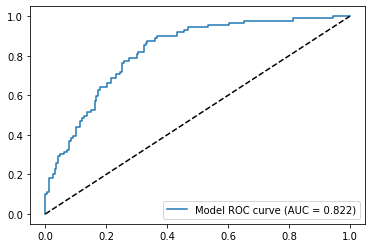

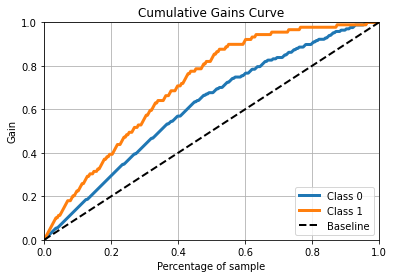

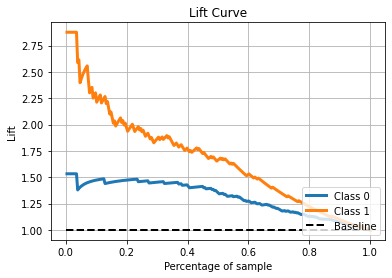

In [8]:
#ROC, Gains and Lift Chart
chart_plot(X_test, y_test, logreg_mod)

In [9]:
#this function find C value with lowest delta between train and test score (generalize)

train_test_scores = []
C_value = []
C_range = [0.001,0.01,0.1,1,10,100,1000] #testing with different range of C value

for C in C_range:
    logreg = LogisticRegression(C=C)
    logreg.fit(X_train,y_train)
    train_test_scores.append((logreg.score(X_train,y_train))-(logreg.score(X_test, y_test)))
    C_value.append(C)

for j in range (len(C_value)):
    
    if train_test_scores[j]==np.min(train_test_scores):
        best_C = C_value[j]
        print('Delta for Train and Test score:', train_test_scores[j])

print('Lowest delta C value:', best_C)
logreg = LogisticRegression(C=best_C)
logreg.fit(X_train,y_train)

print('train score', logreg.score(X_train,y_train))
print('test score', logreg.score(X_test,y_test))

Delta for Train and Test score: -0.00390625
Lowest delta C value: 0.001
train score 0.6484375
test score 0.65234375


# K-NN

In [10]:
#this function find n_neighbors with lowest delta between train and test score (generalize)
train_test_scores = []
neigh_value = []

for i in range(1,15):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train)
    train_test_scores.append((knn.score(X_train,y_train)) - (knn.score(X_test,y_test)))
    neigh_value.append(i)

for j in range (len(neigh_value)):
    
    if train_test_scores[j]==np.min(train_test_scores):
        best_n_neigh = neigh_value[j]
        print('Delta for Train and Test score:', train_test_scores[j])

print('Lowest delta n_neigh:', best_n_neigh, '\n')
knn_mod = KNeighborsClassifier(best_n_neigh)
knn_mod.fit(X_train,y_train)

print('Train score', knn_mod.score(X_train,y_train))
print('Test score', knn_mod.score(X_test,y_test))

Delta for Train and Test score: 0.017578125
Lowest delta n_neigh: 10 

Train score 0.779296875
Test score 0.76171875


In [11]:
#Confusion Matrix & Classification report
report_matrix(X_test, y_test, knn_mod)

Classification report

                precision    recall  f1-score   support

  No Diabetes       0.77      0.90      0.83       167
With Diabetes       0.73      0.49      0.59        89

     accuracy                           0.76       256
    macro avg       0.75      0.70      0.71       256
 weighted avg       0.76      0.76      0.75       256
 

Confusion Matirx

                    Pred No Diabetes  Pred With Diabetes
Act No Diabetes                 151                  16
Act With Diabetes                45                  44


Accuracy = 0.762


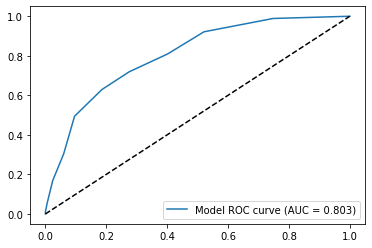

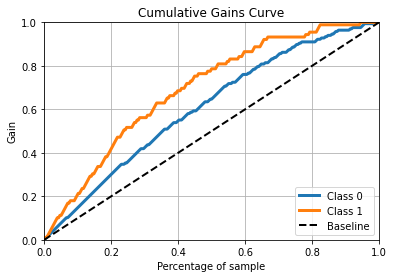

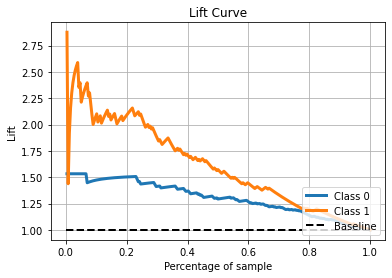

In [12]:
#ROC, Gains and Lift Chart
chart_plot(X_test, y_test, knn_mod)

## K-NN with hyperparameter tuning

In [13]:
#In case of classifier like knn the parameter to be tuned is n_neighbors
param_grid = {'n_neighbors':np.arange(1,50)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X_train,y_train)

print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

Best Score:0.7772701313535123
Best Parameters: {'n_neighbors': 19}


In [14]:
#Confusion Matrix & Classification report
report_matrix(X_test, y_test, knn_cv)

Classification report

                precision    recall  f1-score   support

  No Diabetes       0.76      0.89      0.82       167
With Diabetes       0.68      0.46      0.55        89

     accuracy                           0.74       256
    macro avg       0.72      0.67      0.68       256
 weighted avg       0.73      0.74      0.72       256
 

Confusion Matirx

                    Pred No Diabetes  Pred With Diabetes
Act No Diabetes                 148                  19
Act With Diabetes                48                  41


Accuracy = 0.738


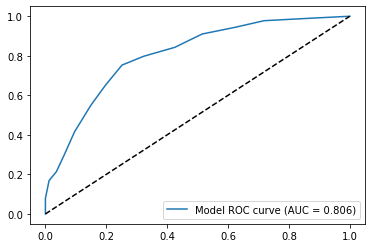

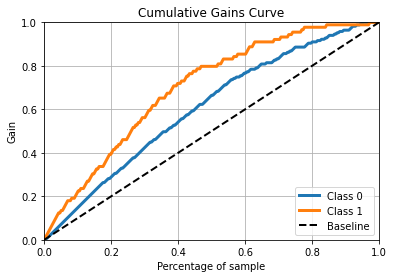

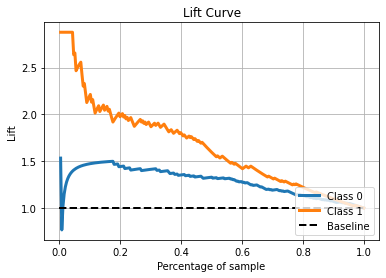

In [15]:
#ROC, Gains and Lift Chart
chart_plot(X_test, y_test, knn_cv)

# Naive Bayes

In [16]:
# Initiating the Gaussian Classifier
nb_mod = GaussianNB()

# Training your model 
nb_mod.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [17]:
#Confusion Matrix & Classification report
report_matrix(X_test, y_test, nb_mod)

Classification report

                precision    recall  f1-score   support

  No Diabetes       0.80      0.79      0.80       167
With Diabetes       0.62      0.64      0.63        89

     accuracy                           0.74       256
    macro avg       0.71      0.72      0.71       256
 weighted avg       0.74      0.74      0.74       256
 

Confusion Matirx

                    Pred No Diabetes  Pred With Diabetes
Act No Diabetes                 132                  35
Act With Diabetes                32                  57


Accuracy = 0.738


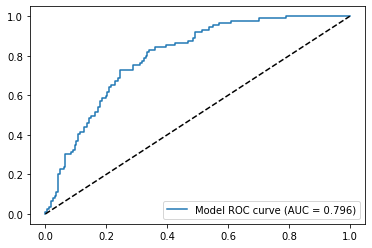

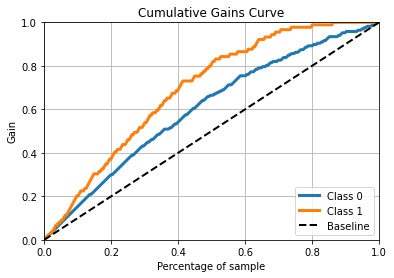

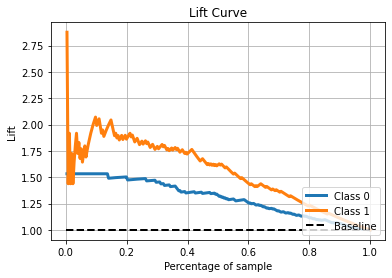

In [18]:
#ROC, Gains and Lift Chart
chart_plot(X_test, y_test, nb_mod)

In [19]:
# You can compare the performance of multiple models in one ROC chart. Wrtie your own codes in the cells below.

## Multiple Models performance ROC charts

Naive Bayes Accuracy score = 0.738
K-Nearest Accuracy score = 0.762
Logistic Reg Accuracy score = 0.727


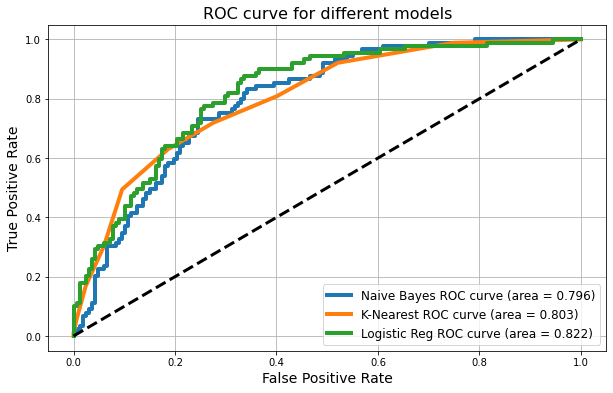

In [20]:
FPR, TPR, THR, ROC_AUC,F1, y_pred, y_pred_proba = {}, {}, {}, {}, {}, {}, {}
model_list = ['', nb_mod, knn_mod, logreg_mod]
model_name = ['Naive Bayes', 'K-Nearest', 'Logistic Reg']

plt.figure(figsize=(10,6))

for i, mod_name in zip((range(1,4)), model_name):
    
    y_pred_proba[i] = model_list[i].predict_proba(X_test)[:,1]
    y_pred[i] = model_list[i].predict(X_test)
    FPR[i], TPR[i], THR[i] = metrics.roc_curve(y_test,y_pred_proba[i])
    ROC_AUC[i]= metrics.roc_auc_score(y_test,y_pred_proba[i])
    F1[i] = metrics.accuracy_score(y_test, y_pred[i])
    plt.plot(FPR[i], TPR[i], label='{} ROC curve (area = %0.3f)'.format(mod_name) % ROC_AUC[i], linewidth=4)
    print('{} Accuracy score = %0.3f'.format(mod_name) % F1[i])

plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC curve for different models', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

# Summary

1) For logistic regression & KNN if hyperparameter tunning is based on score, the model can improve train and test score but it will be potentially overfit. If tuning C value or n_neighbor value according to lowest delta between train and test score can help to generalize the model but usually cannot provide good score.<br>
2) AUC value, accuracy value, F1 score can help to evaluate the model performance but for medical application, recall seems to be a very critical matrix due to False Negative is highly concern for patient's diagnostic.<br>
3) Due to this application in medical field, I will choose Naive Bayes model over logistic regression and KNN because of higher score in recall rate for patient with diabetes (less false negative). 